Here we aim at plotting a world map overlayed by cloud bands of each hemisphere
to obtain a world climatology of cloud band density

0. You must have saved cloud band data first for both hemispheres
1. Load data: list_of_cloud_bands to compute density of cb
2. Load one year for lon, lat

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os

import cartopy.crs as ccrs
import cartopy.util as cutil

import colorcet as cc  # better looking colorblind-proof colormaps

from cloudbandpy.figure_tools import set_fontsize
from cloudbandpy.io_utilities import load_ymlfile, load_data_from_saved_var_files
from cloudbandpy.misc import parse_arguments
from cloudbandpy.time_utilities import (
    add_startend_datetime2config,
    create_list_of_dates,
)
from cloudbandpy.tracking import compute_density

Function to overlay arrays on one map

In [2]:
def overlay_array_on_map_withlatitudes(
    array2overlay: np.ndarray,
    lats2overlay: np.ndarray,
    lats: np.ndarray,
    lons: np.ndarray,
    final_array: np.ndarray = None,
    initial: bool = True,
) -> np.ndarray:
    if initial:
        final_array = np.zeros((len(lats), len(lons)))
    index = np.intersect1d(lats, lats2overlay, return_indices=True)[1]
    final_array[index[::-1], :] += array2overlay
    return final_array

In [3]:
base_dir = "../../"

config_file = os.path.join(base_dir, "config/config_analysis_world_cb_density.yml")
config = load_ymlfile(config_file, isconfigfile=True)

# Make sure the dates are covering the whole period
config_copy = config.copy()
config_copy["startdate"] = "19590101.00"
config_copy["enddate"] = "20211231.00"
config_copy["load_saved_files"] = True

add_startend_datetime2config(config_copy)
list_of_dates = create_list_of_dates(config_copy)

2024-01-05 11:07:41,304 - io_utilities.load_ymlfile - INFO: Configuration file loaded


In [4]:
# 1.1 Create latitudes and longitudes that match the 0.5 degree ERA5 data
lats_globe = np.arange(90, -90.5, -0.5)
lons_globe = np.arange(0, 360, 0.5)

# 1.2 Create latitudes of southern hemisphere
# Since we make a map of the world, longitudes stay identical
config_copy["lat_north"] = -10
config_copy["lat_south"] = -50
latssh = np.arange(config_copy["lat_north"], config_copy["lat_south"] - 0.5, -0.5)

# 1.3 Load cloud bands from the southern hemisphere (default config_copy is for southern hemisphere)
listofdates = create_list_of_dates(config_copy)
list_of_cloud_bandssh = load_data_from_saved_var_files(
    config_copy, varname="list_of_cloud_bands"
)

# 1.4 Compute density for the southern hemisphere
ntot_cbsh, densitysh = compute_density(
    dates=listofdates, list_of_cloud_bands=list_of_cloud_bandssh
)

2024-01-05 11:07:41,315 - io_utilities.load_data_from_saved_var_files - INFO: Load data from: 19590101.00 to 20211231.00


In [5]:
# 2.1 Load cloud bands and dates from the northern hemisphere
config_copy["domain"] = "northernhemisphere"
config_copy["lat_north"] = 50
config_copy["lat_south"] = 10
list_of_cloud_bandsnh = load_data_from_saved_var_files(
    config_copy, varname="list_of_cloud_bands"
)

# 2.2 Create latitudes of northern hemisphere
latsnh = np.arange(config_copy["lat_south"], config_copy["lat_north"] + 0.5, +0.5)

# 2.3 Compute density for the northern hemisphere
ntot_cbnh, densitynh = compute_density(
    dates=listofdates, list_of_cloud_bands=list_of_cloud_bandsnh
)

2024-01-05 11:08:31,543 - io_utilities.load_data_from_saved_var_files - INFO: Load data from: 19590101.00 to 20211231.00


In [6]:
# 3. Overlay southern hemisphere densities over an empty world map
world_density = overlay_array_on_map_withlatitudes(
    array2overlay=densitysh,
    lats2overlay=latssh,
    lats=lats_globe,
    lons=lons_globe,
    initial=True,
)


In [7]:
# Overlay northern hemisphere densities over world map
world_density = overlay_array_on_map_withlatitudes(
    array2overlay=densitynh,
    lats2overlay=latsnh,
    lats=lats_globe,
    lons=lons_globe,
    final_array=world_density,
    initial=False,
)

Create world map of cloud band density

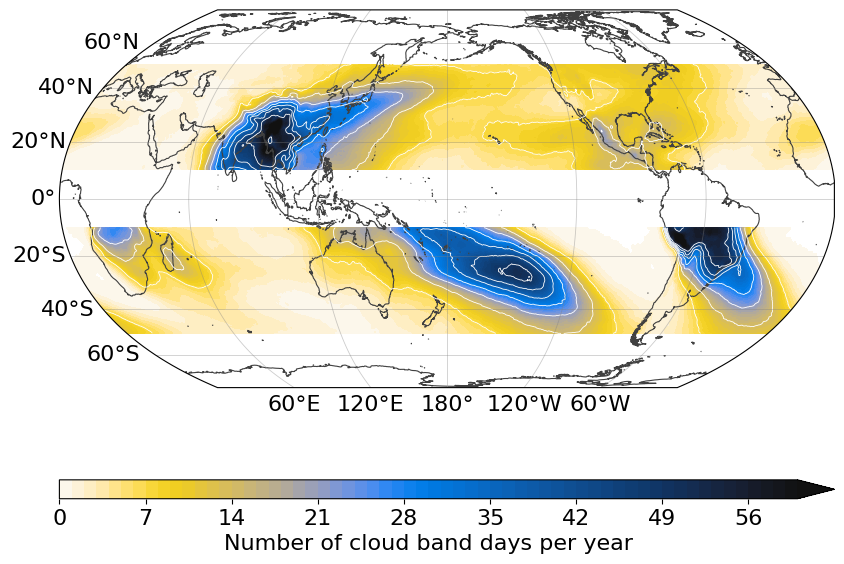

In [8]:
cworld_density, clons = cutil.add_cyclic_point(world_density, lons_globe)
set_fontsize(size=16)
cmap = plt.get_cmap("cet_CET_CBL2_r")  # If you prefer to keep using get_cmap

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.EqualEarth(central_longitude=180))
fill = ax.contourf(
    lons_globe,
    lats_globe,
    np.ma.masked_where(world_density == 0, world_density),
    transform=ccrs.PlateCarree(),
    levels=range(0, 61, 1),
    cmap=cmap,
    extend="max",
)
# add contours every 7 days
ax.contour(
    lons_globe,
    lats_globe,
    np.ma.masked_where(world_density == 0, world_density),
    transform=ccrs.PlateCarree(),
    levels=range(0, 56, 7),
    linewidths=0.6,
    colors="white",
)
ax.coastlines("50m", color="#404040", linewidth=0.8)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.6, color="gray", alpha=0.4, linestyle="-")
gl.top_labels = False
gl.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
gl.xlocator = mticker.FixedLocator([60, 120, 180, -120, -60])
# Add colorbar
axins = inset_axes(ax, width="100%", height="5%", loc="lower center", borderpad=-5)
cbar = fig.colorbar(fill, cax=axins, orientation="horizontal")
cbar.set_label("Number of cloud band days per year")

In [9]:
# figname = f"./number_days_cloud_band_per_year_{config_copy['datetime_startdate'].year}_{config_copy['datetime_enddate'].year}_world_cont7days.png"
# fig.savefig(figname, dpi=250, bbox_inches="tight")
